<a href="https://www.kaggle.com/code/nabarajsubedi/transformer-captioning-mlflow?scriptVersionId=159330959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import keras
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
import pandas as pd

# Specify the path to the Stanford Paragraph Captioning dataset file
dir_Stanford_text = '/kaggle/input/standford-paragraph-nepali-dataset/Caption_final.csv'

# Read the Stanford Paragraph Captioning dataset
data = pd.read_csv(dir_Stanford_text, delimiter=',')

# Remove unwanted rows if needed
# data = data[data['train'] == 'TRUE']  # Adjust as needed
print(data.columns)

# Reorganize the columns
data = data[['Image_name','Paragraph']]

# Display the first few rows of the DataFrame
data.head()

Index(['Image_name', 'Paragraph', 'train', 'test', 'val'], dtype='object')


,Image_name,Paragraph
0,2356347,यसको अगाडि झ्यालहरूमा बारहरू भएको ठूलो भवन। भव...
1,2317429,एउटा सेतो गोलो प्लेट एउटा टेबलमा छ जसमा प्लास...
2,2414610,नीलो टेनिस पोशाकमा एउटी महिला हरियो टेनिस कोर्...
3,2365091,एउटा ठुलो रातो र सेतो रेलले ग्रामीण क्षेत्र जस...
4,2383120,धेरै सफा र सफा बाथरूम। सबै चीज सफा पोर्सिलेन स...


NameError: name 'nepali_font' is not defined

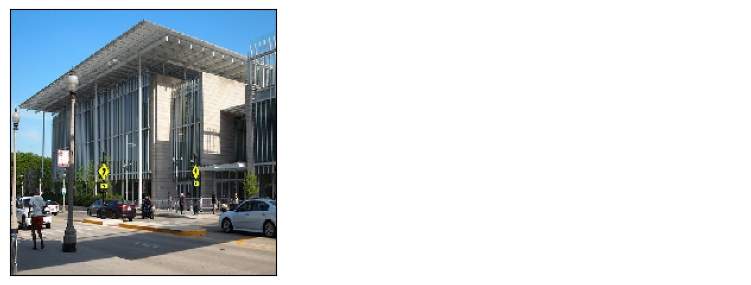

In [4]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import os

npic = 5
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10, 20))

# Assuming you have loaded the Stanford Paragraph Captioning dataset into 'data'
# and set the appropriate path to the image directory
image_path = '/kaggle/input/standford-paragraph-nepali-dataset/stanford_images'

# Extract unique filenames from the dataset
uni_filenames = data["Image_name"].unique()

for jpgfnm in uni_filenames[:5]:
    filename = os.path.join(image_path, str(jpgfnm)+'.jpg')  # Convert jpgfnm to string
    captions = list(data["Paragraph"].loc[data["Image_name"] == jpgfnm].values)

    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=10, fontproperties=nepali_font)   # Adjusted fontsize
    count += 1

plt.show()


In [ ]:
vocabulary = []
for txt in data.Paragraph.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

In [ ]:
img = data["Image_name"].tolist()
caption = data["Paragraph"].tolist()

In [ ]:
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

In [5]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [6]:
def text_clean(text_original):
#     text = remove_punctuation(text_original)
#     text = remove_single_character(text)
#     text = remove_numeric(text)
    return(text_original)

for i, caption in enumerate(data.Paragraph.values):
    newcaption = text_clean(caption)
    data["Paragraph"].iloc[i] = newcaption

In [7]:
data["Paragraph"][8]

'एक जोडी खाना खाने तयारी गर्दैछन्। तिनीहरू टेबल क्षेत्रमा छन् र आफ्नै लागि खाना समात्छन्। पृष्ठभूमिमा थोरै देखिने व्यक्ति मात्र क्यामेरातिर हेरिरहेको छ।'

In [8]:
clean_vocabulary = []
for txt in data.Paragraph.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 27661


**FROM HERE**

In [65]:
all_captions = []

for caption  in data["Paragraph"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:10]

['<start> यसको अगाडि झ्यालहरूमा बारहरू भएको ठूलो भवन। भवन अगाडि मानिसहरु हिडिरहेका छन्। भवनको अगाडि एउटा सडक छ जसमा धेरै कारहरू छन्। <end>',
 '<start>  एउटा सेतो गोलो प्लेट एउटा टेबलमा छ जसमा प्लास्टिकको कपडा छ। सेतो प्लेटमा सुनको पहेँलो फ्रेन्च फ्राइजको परिकारसँगै पन्नीले ढाकिएको खानाको दुई भागहरू छन्। छोटो, टपलेस, प्लास्टिक कन्टेनरमा सेतो प्लेटको छेउमा सेतो चटनी छ। सेतो प्लेटमा विकर्ण धेरै अन्य स्ट्याक्ड प्लेटहरूको किनारहरू हुन्। कालो छायाहरू टेबलमा प्रतिबिम्बित छन्। <end>',
 '<start> नीलो टेनिस पोशाकमा एउटी महिला हरियो टेनिस कोर्टमा उभिरहेकी छिन्। उनी नीलो टेनिस रैकेट घुमाइरहेकी छिन्। उनको टाउको माथि हरियो टेनिस बल छ। <end>',
 '<start> एउटा ठुलो रातो र सेतो रेलले ग्रामीण क्षेत्र जस्तो देखिने ट्र्याकमा यात्रा गरिरहेको छ। पृष्ठभूमिमा रूख र पहाडहरू छन् र जमिन सुख्खा देखिन्छ। यात्रुहरूलाई बाहिर हेर्नको लागि ट्रेनमा धेरै ठूला झ्यालहरू छन्। ट्रेनको अगाडिको माथिल्लो भागमा रातो र छेउमा रातो पट्टी र ट्रिमको साथ प्रायः सेतो हुन्छ। रेलको छाना खरानी छ। <end>',
 '<start> धेरै सफा र सफा बाथरूम। स

In [66]:
# PATH = "/kaggle/input/standford-paragraph-nepali-dataset/stanford_images/"
PATH = "/kaggle/working/NumpyFiles/"
all_img_name_vector = []

for annot in data["Image_name"]:
    full_image_path = PATH + str(annot)+'.jpg'

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/kaggle/working/NumpyFiles/2356347.jpg',
 '/kaggle/working/NumpyFiles/2317429.jpg',
 '/kaggle/working/NumpyFiles/2414610.jpg',
 '/kaggle/working/NumpyFiles/2365091.jpg',
 '/kaggle/working/NumpyFiles/2383120.jpg',
 '/kaggle/working/NumpyFiles/2333990.jpg',
 '/kaggle/working/NumpyFiles/2388203.jpg',
 '/kaggle/working/NumpyFiles/2338364.jpg',
 '/kaggle/working/NumpyFiles/2410301.jpg',
 '/kaggle/working/NumpyFiles/2404368.jpg']

In [67]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 20359
len(all_captions) : 20359


In [68]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [69]:
train_captions,img_name_vector = data_limiter(20359,all_captions,all_img_name_vector)

In [70]:
len(train_captions)

20359

In [71]:
print(f"len(all_img_name_vector) : {len(img_name_vector)}")
print(f"len(all_captions) : {len(train_captions)}")

len(all_img_name_vector) : 20359
len(all_captions) : 20359


**UPTO HERE**

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 [==============================] - 0s 0us/step


In [22]:
# Get unique images
import os
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))


  output_directory = '/kaggle/working/NumpyFiles/'
  for bf, p in zip(batch_features, path):
        file_name = os.path.basename(p.numpy().decode("utf-8")) + '.npy'
        path_of_feature = os.path.join(output_directory, file_name)
        np.save(path_of_feature, bf.numpy())
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

 99%|█████████▊| 1254/1272 [04:29<00:13,  1.38it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
 99%|█████████▊| 1256/1272 [04:31<00:11,  1.36it/s]Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
100%|██████████| 1272/1272 [04:39<00:00,  4.56it/s]


In [23]:
len(path_of_feature)

38

### Preprocess and tokenize the captions

In [72]:
top_k = 25000

In [73]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [74]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [75]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [76]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [77]:
cap_vector.shape

(20359, 240)

### Split the data into training and testing

In [78]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [79]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(16287, 16287, 4072, 4072)

### Create a tf.data dataset for training

In [80]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [81]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [83]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# # Use map to load the numpy files in parallel
# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func, [item1, item2], [tf.float32, tf.int32]),
#           num_parallel_calls=tf.data.experimental.AUTOTUNE)

# # Shuffle and batch
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**.........**

In [35]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [36]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [37]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [38]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [39]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [40]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [41]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [42]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [44]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size,
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [46]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [47]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

**.....**

In [48]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float32
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float32

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is a float32

        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    

In [50]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [51]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [52]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [53]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')

In [54]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [55]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [89]:
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    dec_mask = create_masks_decoder(tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp,
                                     True,
                                     dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)


@tf.function
def val_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    dec_mask = create_masks_decoder(tar_inp)

    # Note: No gradient tape for validation step
    predictions, _ = transformer(img_tensor, tar_inp,
                                 False,  # Set training=False during validation
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

    val_loss(loss)
    val_accuracy(tar_real, predictions)


In [97]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Checkpoint callback to save model weights
checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=False, period=10)

# Initialize lists for storing metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    # Reset metrics at the start of each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # Training
    for img_tensor, tar in train_dataset:
        train_step(img_tensor, tar)

    # Validation
    for img_tensor, tar in val_dataset:
        val_step(img_tensor, tar)
        
     # Store metrics for plotting
    train_losses.append(train_loss.result())
    train_accuracies.append(train_accuracy.result() * 100)
    val_losses.append(val_loss.result())
    val_accuracies.append(val_accuracy.result() * 100)

    # Print metrics at the end of each epoch
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100))

    # Save model as TensorFlow SavedModel every 10 epochs
    if (epoch + 1) % 10 == 0:
        transformer.save("/kaggle/working/saved_model/epoch_{}".format(epoch + 1))

# Optionally, you can also save the final model
transformer.save("/kaggle/working/final_model")



Epoch 1, Loss: 4.097532749176025, Accuracy: 5.194712162017822, Val Loss: 5.040322780609131, Val Accuracy: 4.013701915740967
Epoch 2, Loss: 3.8952255249023438, Accuracy: 5.491352558135986, Val Loss: 4.866708278656006, Val Accuracy: 4.235917091369629
Epoch 3, Loss: 3.7117252349853516, Accuracy: 5.7474541664123535, Val Loss: 4.714332103729248, Val Accuracy: 4.436025142669678


In [1]:
!pip install nltk pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 11.4 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for pycocotools>=2.0.2 from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 23.5 MB/s eta 0:00:00


In [121]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(6, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/training_validation_loss.png")  # Save the plot
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig("/kaggle/working/training_validation_accuracy.png")  # Save the plot
plt.show()


In [119]:
# import tensorflow as tf

# # Specify the path where the SavedModel is saved
# saved_model_path = "/kaggle/working/final_model"

# try:
#     # Try loading the saved model
#     loaded_model = tf.keras.models.load_model(saved_model_path)
#     print("Model loaded successfully!")

#     # Now, you can use the loaded_model for predictions, evaluation, etc.

# except Exception as e:
#     print(f"An error occurred while loading the model: {e}")


Model loaded successfully!


In [115]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']

  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)

      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)

      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

In [116]:
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming evaluate function is defined to generate captions
def evaluate_single_image(image_path):
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    
    # Evaluate the caption for the given image
    caption, _, _ = evaluate(image_path)

    # Remove "<unk>" from the result
    caption = [word for word in caption if word != "<unk>"]

    # Remove <end> from the result
    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]

    # Display captions
    print('Real Caption:', real_caption)
    print('Predicted Caption:', result_final)

    # Display the image
    temp_image = np.array(Image.open(image_path))
    plt.imshow(temp_image)
    plt.show()

# Select a specific image path for testing
test_image_path = '/kaggle/input/standford-paragraph-nepali-dataset/stanford_images/1067.jpg'
evaluate_single_image(test_image_path)


ValueError: Exception encountered when calling layer 'transformer' (type Transformer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (6 total):
    * <tf.Tensor 'inp:0' shape=(1, 64, 2048) dtype=float32>
    * <tf.Tensor 'tar:0' shape=(1, 1) dtype=int32>
    * False
    * <tf.Tensor 'look_ahead_mask:0' shape=(1, 1, 1, 1) dtype=float32>
    * None
    * None
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (6 total):
    * TensorSpec(shape=(None, 64, 2048), dtype=tf.float32, name='inp')
    * TensorSpec(shape=(None, 239), dtype=tf.int32, name='tar')
    * True
    * TensorSpec(shape=(None, 1, 239, 239), dtype=tf.float32, name='look_ahead_mask')
    * None
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (6 total):
    * TensorSpec(shape=(None, 64, 2048), dtype=tf.float32, name='inp')
    * TensorSpec(shape=(None, 239), dtype=tf.int32, name='tar')
    * False
    * TensorSpec(shape=(None, 1, 239, 239), dtype=tf.float32, name='look_ahead_mask')
    * None
    * None
  Keyword arguments: {}

Call arguments received by layer 'transformer' (type Transformer):
  • tar=tf.Tensor(shape=(1, 64, 2048), dtype=float32)
  • training=tf.Tensor(shape=(1, 1), dtype=int32)
  • look_ahead_mask=False
  • dec_padding_mask=tf.Tensor(shape=(1, 1, 1, 1), dtype=float32)
  • enc_padding_mask=None

In [105]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /kaggle/working/NumpyFiles/2316488.jpg; No such file or directory [Op:ReadFile]

In [139]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /kaggle/working/NumpyFiles/2362657.jpg; No such file or directory [Op:ReadFile]

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


BLEU-1 score: 20.833333333333336
BLEU-2 score: 13.315591032282686
BLEU-3 score: 9.45777372259606
BLEU-4 score: 14.011697931222914
Real Caption: एउटा खैरो र सेतो गाई बगैंचामा उभिएको छ। गाईको छेउमा जमिनमा पहेँलो फूलहरू छन्। बारको अर्को छेउमा मानिसहरू उभिरहेका छन्।
Predicted Caption: एउटा ठूलो सेतो भवन जसको अगाडि स्तम्भहरू छन्। एउटा चाँदीको भ्यान भित्र छ र एउटा खैरो कुकुर सेतो अनुहारको छेउमा उभिएको छ। गाईको पछाडि खैरो गाई उभिएको छ। तिनीहरूको पछाडि हरियो बार छ। गाईको पछाडि खैरो बार छ। गाईको पछाडि एउटा चिन्ह छ जुन खैरो र हरियो छ।


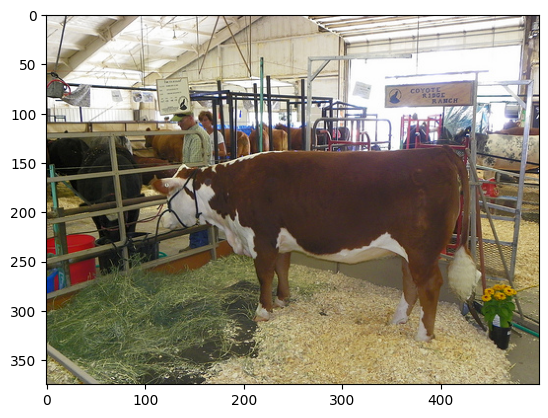

In [94]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption
score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


Standard testing for BLEU,METEOR,CIDER,SPICE


In [156]:
!pip install nltk git+https://github.com/mbforbes/pycocoevalcap

  Cloning https://github.com/mbforbes/pycocoevalcap to /tmp/pip-req-build-dzswhoo1
  Running command git clone --filter=blob:none --quiet https://github.com/mbforbes/pycocoevalcap /tmp/pip-req-build-dzswhoo1
Username for 'https://github.com': ^C
ERROR: Operation cancelled by user


In [157]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from PIL import Image
import matplotlib.pyplot as plt

# ... (your previous imports and definitions)

start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption, result, attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

# remove "<unk>" in result
caption = [word for word in caption if word != "<unk>"]
real_caption = [word for word in real_caption if word != "<unk>"]

# remove <end> from result
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption)
reference = real_appn
candidate = caption

# Calculate BLEU scores
score_bleu_1 = sentence_bleu([reference], candidate, weights=(1.0, 0, 0, 0)) * 100
score_bleu_2 = sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0)) * 100
score_bleu_3 = sentence_bleu([reference], candidate, weights=(0.3, 0.3, 0.3, 0)) * 100
score_bleu_4 = sentence_bleu([reference], candidate, weights=(0.25, 0.25, 0.25, 0.25)) * 100

print(f"BLEU-1 score: {score_bleu_1}")
print(f"BLEU-2 score: {score_bleu_2}")
print(f"BLEU-3 score: {score_bleu_3}")
print(f"BLEU-4 score: {score_bleu_4}")

# Calculate METEOR score
score_meteor = meteor_score([reference], candidate) * 100
print(f"METEOR score: {score_meteor}")

# Calculate CIDEr score
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score({0: reference}, {0: candidate})
print(f"CIDEr score: {cider_score * 100}")

# Calculate SPICE score
spice_scorer = Spice()
spice_score, _ = spice_scorer.compute_score({0: reference}, {0: candidate})
print(f"SPICE score: {spice_score * 100}")

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)
plt.show()


ModuleNotFoundError: No module named 'nltk.translate.meteor_score'

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.meteor_score import meteor_score

# Assuming evaluate, img_name_val, cap_val, and tokenizer are defined somewhere

# Replace these lines with your tokenization and image evaluation logic
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption, result, attention_weights = evaluate(image)

# Extract actual words from <unk> and <end>
caption = [word for word in caption if word != "<unk>"]
real_caption = [word for word in real_caption if word != "<unk>"]
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

# Calculate METEOR score
reference = [real_caption]
candidate = caption
meteor = meteor_score(reference, candidate)
print(f"METEOR score: {meteor * 100}")

# Print real and predicted captions
print('Real Caption:', ' '.join(real_caption))
print('Predicted Caption:', ' '.join(caption))

# Display the image
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)
plt.show()


ModuleNotFoundError: No module named 'nltk.translate.meteor_score'

CIDER

Real Caption: < s t a r t >   ए उ ट ा   त स ् व ी र ल े   ध े र ै   स ड क   च ि न ् ह ह र ू   द े ख ा उ ँ छ ।   च ि न ् ह ह र ू   क ु न ै   प न ि   र ं ग   ह ु न ् ।   श ी र ् ष   च ि न ् ह   अ ल ि   ख ि य ा   छ ।   द ो स ् र ो   च ि न ् ह म ा   प े न ् ट   ह र ा उ ँ द ै छ ।   च ि न ् ह ह र ू म ा   स ड क क ो   न ा म ह र ू   छ न ् ।   प ृ ष ् ठ भ ू म ि   न ी ल ो   छ ।   च ि न ् ह ह र ू   आ य त ा क ा र   आ क ा र   ह ु न ् ।   च ि न ् ह ह र ू   व ि भ ि न ् न   आ क ा र क ा   ह ु न ् छ न ् ।   त ् य ह ा ँ   च ा र   स ं क े त ह र ू   छ न ् ।   स ं क े त ह र ू   अ ष ् ट ् र े ल ि य ा क ा   स ड क ह र ू क ो   ल ा ग ि   ह ु न ् ।   < e n d >
Predicted Caption: एउटा ठूलो सेतो र सेतो भवन छ। भवनको छेउमा एउटा ठूलो सेतो भवन छ।


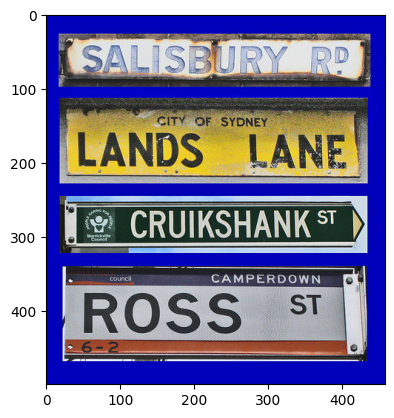

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate import bleu_score
# from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from nltk.translate.cider import Cider

# Assuming evaluate, img_name_val, cap_val, and tokenizer are defined somewhere

# Replace these lines with your tokenization and image evaluation logic
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption, result, attention_weights = evaluate(image)

# Extract actual words from <unk> and <end>
caption = [word for word in caption if word != "<unk>"]
real_caption = [word for word in real_caption if word != "<unk>"]
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

# Prepare reference and candidate for CIDEr
reference = [{'image_id': 0, 'caption': ' '.join(real_caption)}]
candidate = {0: [result_final]}

# Calculate CIDEr score
# cider_scorer = Cider()
# cider_score, _ = cider_scorer.compute_score(reference, candidate)
# print(f"CIDEr score: {cider_score * 100}")

# Print real and predicted captions
print('Real Caption:', ' '.join(real_caption))
print('Predicted Caption:', ' '.join(caption))

# Display the image
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)
plt.show()
